In [5]:
#importar las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, Binarizer, RobustScaler, label_binarize
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_text, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [6]:
seed=12345 #fijamos la semilla de aleatorización para que sea la misma en todo el proceso
#Reemplaza con la ruta correcta y nombre de tu archivo
file_path = 'C:/Users/user/OneDrive - Universidad Complutense de Madrid (UCM)/Documentos/Titulo Propio/Machine Learning/Redes Neuronales/Python/compress.csv' 
#convertir a data frame el archivo
df = pd.read_csv(file_path)
print(df.head())
#La variable de interés es strength
#analizamos la frecuencia de cada clase
print(f'\n Instancias: {df.shape[0]}; Variables: {df.shape[1]}')

   Cement (component 1)(kg in a m^3 mixture)  \
0                                      540.0   
1                                      540.0   
2                                      332.5   
3                                      332.5   
4                                      198.6   

   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                                0.0       
1                                                0.0       
2                                              142.5       
3                                              142.5       
4                                              132.4       

   Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         0.0   
4                                         0.0   

   Water  (component 4)(kg in a m^3 mixture)  \
0      

In [7]:
#renombramos variables para usarlas más cómodamente
nuevos_nombres = ['cement', 'blast','ash','water','plasticizer','coarse','fine','day','strength']

# Asignar nuevos nombres a las columnas
df.columns = nuevos_nombres
print("\nDataFrame con columnas renombradas:")
print(df)


DataFrame con columnas renombradas:
      cement  blast    ash  water  plasticizer  coarse   fine  day  strength
0      540.0    0.0    0.0  162.0          2.5  1040.0  676.0   28     79.99
1      540.0    0.0    0.0  162.0          2.5  1055.0  676.0   28     61.89
2      332.5  142.5    0.0  228.0          0.0   932.0  594.0  270     40.27
3      332.5  142.5    0.0  228.0          0.0   932.0  594.0  365     41.05
4      198.6  132.4    0.0  192.0          0.0   978.4  825.5  360     44.30
...      ...    ...    ...    ...          ...     ...    ...  ...       ...
1025   276.4  116.0   90.3  179.6          8.9   870.1  768.3   28     44.28
1026   322.2    0.0  115.6  196.0         10.4   817.9  813.4   28     31.18
1027   148.5  139.4  108.6  192.7          6.1   892.4  780.0   28     23.70
1028   159.1  186.7    0.0  175.6         11.3   989.6  788.9   28     32.77
1029   260.9  100.5   78.3  200.6          8.6   864.5  761.5   28     32.40

[1030 rows x 9 columns]


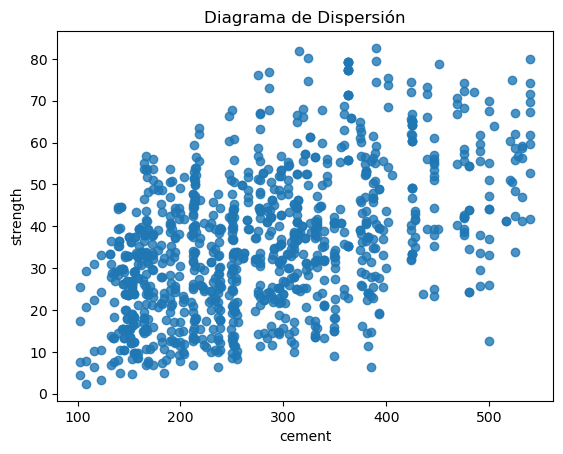

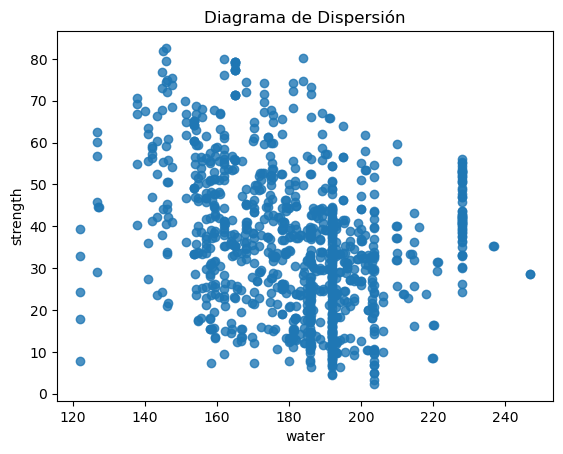

In [8]:
# representamos la relación enre la variable de interés y las variables input
# relaciones no lineales, aparente buen escenario para el uso de redes
sns.regplot(x=df['cement'], y=df['strength'], ci=None,fit_reg=False)
plt.xlabel('cement')
plt.ylabel('strength')
plt.title('Diagrama de Dispersión')
plt.show()


# Crear el diagrama de dispersión con regresión
sns.regplot(x=df['water'], y=df['strength'], ci=None,fit_reg=False)
plt.xlabel('water')
plt.ylabel('strength')
plt.title('Diagrama de Dispersión')
plt.show()

In [9]:
# hay valores perdidos?
df.isna().sum()

cement         0
blast          0
ash            0
water          0
plasticizer    0
coarse         0
fine           0
day            0
strength       0
dtype: int64

Preparamos la base de datos para la aplicación de redes neuronales:

    - Estandarizar/normalizar variables continuas
    - Convertir a dummies las variables categóricas
    - Evitar missing

In [10]:
# organiza las variables según su naturaleza
#hacer una lista con las variables input numericas
num_cols = ['cement', 'blast','ash','water','plasticizer','coarse','fine','day','strength']
#hacer una lista con las variables input categóricas: no hay

In [11]:
#Normalizar variables numericas
#Si se quisieran estandarizar, scaler=StandardScaler()
scaler = MinMaxScaler() #selecciona el transformador
X = df[num_cols] #selecciona las variables numéricas que se quieren transformar y las guarda en un nuevo dataframe
X_scale = pd.DataFrame(scaler.fit_transform(X)) #guarda el resultado de la transformación de las variables de X en X_scale
X_scale.columns = X.columns #para simplificar los nombres, asigna a las columnas de X_scale los nombres de las variables de X_num
df[num_cols] = X_scale
#OJO: incluye el target
print(df.head())

     cement     blast  ash     water  plasticizer    coarse      fine  \
0  1.000000  0.000000  0.0  0.321086      0.07764  0.694767  0.205720   
1  1.000000  0.000000  0.0  0.321086      0.07764  0.738372  0.205720   
2  0.526256  0.396494  0.0  0.848243      0.00000  0.380814  0.000000   
3  0.526256  0.396494  0.0  0.848243      0.00000  0.380814  0.000000   
4  0.220548  0.368392  0.0  0.560703      0.00000  0.515698  0.580783   

        day  strength  
0  0.074176  0.967485  
1  0.074176  0.741996  
2  0.739011  0.472655  
3  1.000000  0.482372  
4  0.986264  0.522860  


In [12]:
# Separar las variables predictoras y la variable de respuesta.
# El grupo de variables predictoras se define y se fija
X = df[['cement','blast','water']] #en X las variables ya están normalizadas y con dummies
y = df['strength']
#primer approach a red neuronal: definimos la estructura
red1 = MLPRegressor(random_state=seed, hidden_layer_sizes=(5),activation='tanh',
                     alpha=0.001,solver='adam',max_iter=300)
# Dividir los datos en entrenamiento y test (20% de los datos para test)
#X e y están escalados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# Construir el modelo de red ajustando los pesos a datos de train
red1.fit(X_train, y_train)


MLPRegressor(activation='tanh', alpha=0.001, hidden_layer_sizes=5, max_iter=300,
             random_state=12345)

### - Probar con 200 iteraciones, qué pasa?

- Modificar la estructura de red: ¿qué cantidad de nodos ocultos es apropiada?
En este ejemplo, k=3. Como hay 1030 observaciones y hemos usado tres variables input, si se reservan aproximandamente 20 observaciones para cada parámetro,la fórmula nos dice que una cantidad razonable de nodos ocultos es ~10

In [13]:
# una vez ajustado el modelo en datos de train, lo evaluamos en datos de test
# es importante comparar los resultados en tr/ts para evitar underfiiting/overfitting
# Predicciones en el conjunto de entrenamiento y prueba
y_train_pred = red1.predict(X_train)
y_test_pred = red1.predict(X_test)

# Calcular métricas de rendimiento
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'MSE en conjunto de entrenamiento: {mse_train:.4f}')
print(f'MSE en conjunto de prueba: {mse_test:.4f}')
print(f'R2 en conjunto de entrenamiento: {r2_train:.4f}')
print(f'R2 en conjunto de prueba: {r2_test:.4f}')

MSE en conjunto de entrenamiento: 0.0463
MSE en conjunto de prueba: 0.0523
R2 en conjunto de entrenamiento: -0.0943
R2 en conjunto de prueba: -0.1155


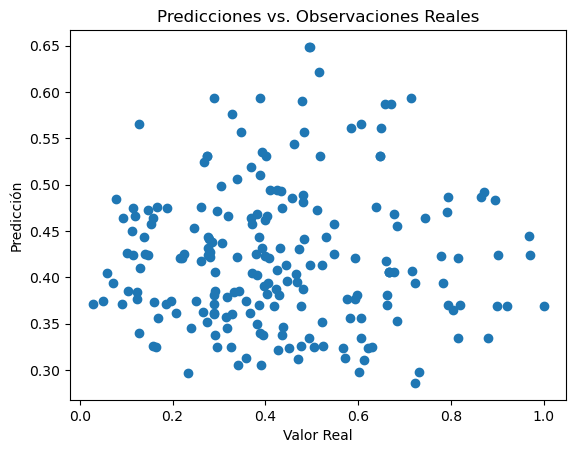

In [14]:
# Graficar predicciones vs. observaciones reales
plt.scatter(y_test, y_test_pred)
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Predicciones vs. Observaciones Reales')
plt.show()

In [16]:
#Aplicamos validación cruzada para obtener una evaluación más robusta
cv_scores = cross_val_score(red1, X, y, cv=5, scoring='neg_mean_squared_error')
cv_mse_mean = -np.mean(cv_scores)

print(f'MSE promedio mediante validación cruzada: {cv_mse_mean:.4f}')

MSE promedio mediante validación cruzada: 0.0519
